In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import re
import glob
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [ ]:
audio_file_path="/content/drive/MyDrive/FYP 2023/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav"
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [ ]:
print(librosa_audio_data)

[0.05311411 0.11161216 0.15054351 ... 0.13371423 0.14862993 0.15350561]


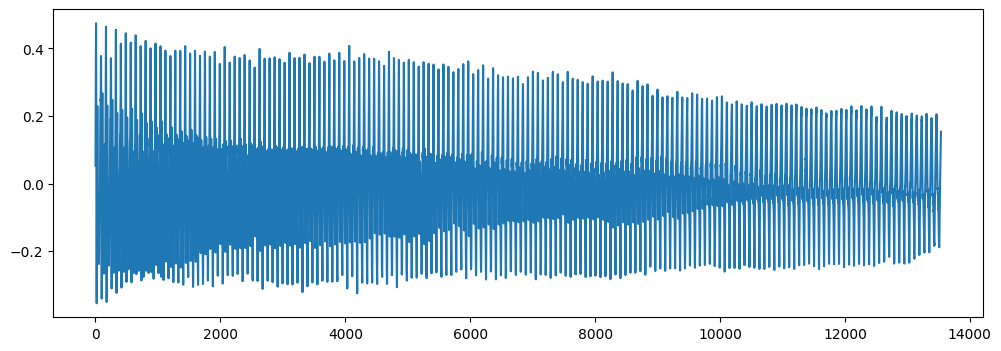

In [ ]:
###plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [ ]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs)

[[-1.47608582e+02 -1.53865601e+02 -1.99033615e+02 ... -2.51541382e+02
  -2.36929749e+02 -1.90925339e+02]
 [ 1.48926697e+02  1.23503174e+02  8.42529221e+01 ...  1.02713364e+02
   1.14698898e+02  1.19505615e+02]
 [-7.85590029e+00 -9.86245537e+00 -2.99000320e+01 ... -8.45829773e+00
   2.84758985e-01  1.42831688e+01]
 ...
 [ 6.13279915e+00  5.30811501e+00  3.80148292e-02 ...  1.10820889e-01
   7.67016172e-01  1.99491799e-01]
 [-6.41952515e+00 -7.70901537e+00 -1.37894650e+01 ... -1.63822479e+01
  -1.71555443e+01 -1.23915768e+01]
 [-5.48798752e+00 -7.95367813e+00 -5.76490402e+00 ... -2.13646841e+00
  -1.33829102e-01 -4.63048840e+00]]


In [ ]:
def features_extractor_MFCC(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [ ]:
count_healthy = 0
count_non_healthy = 0
def features_extractor_currect_folder(foldername,label):
  global count_healthy, count_non_healthy
  label_feature=[]
  for filename in tqdm(glob.glob(foldername+'/*.wav')):
    if label == 0:
      count_non_healthy = count_non_healthy + 1
    else:
      count_healthy = count_healthy + 1
    data=features_extractor_MFCC(filename)
    label_feature.append([data,label])
    # print((label_feature))
  return label_feature

In [ ]:
label_features=[]
folder_path='/content/drive/MyDrive/FYP 2023/Dataset'
folders_labels=[
    [flder, 1 if 'healthy' in flder[len(folder_path):]
     else 0
    ]
    for flder in glob.glob(folder_path+'/*')
    ]
print(folders_labels)
for folder , label in (folders_labels):
  label_features.extend(features_extractor_currect_folder(folder,label))
 # print(label_features)
  # break

[['/content/drive/MyDrive/FYP 2023/Dataset/female_Hyperfunktionelle_Dysphonie', 0], ['/content/drive/MyDrive/FYP 2023/Dataset/female_laryngitis', 0], ['/content/drive/MyDrive/FYP 2023/Dataset/male_Hyperfunktionelle_Dysphonie', 0], ['/content/drive/MyDrive/FYP 2023/Dataset/male_laryngitis', 0], ['/content/drive/MyDrive/FYP 2023/Dataset/female_healthy', 1], ['/content/drive/MyDrive/FYP 2023/Dataset/male_healthy', 1]]


100%|██████████| 448/448 [00:16<00:00, 26.37it/s]


In [ ]:
# print((label_features[0][0]))
class_0 = [item for item in label_features if item[1] == 0]
class_1 = [item for item in label_features if item[1] == 1]
print(len(class_0))
print(len(class_1))
count_class_0 = len(class_0)
count_class_1 = len(class_1)
if count_class_0 < count_class_1:
    class_1_resampled = random.sample(class_1, count_class_0)
    balanced_data = class_0 + class_1_resampled
else:
    class_0_resampled = random.sample(class_0, count_class_1)
    balanced_data = class_0_resampled + class_1

random.shuffle(balanced_data)
label_features = balanced_data
class_0 = [item for item in label_features if item[1] == 0]
class_1 = [item for item in label_features if item[1] == 1]
print(len(class_0))
print(len(class_1))


1897
981
981
981


In [ ]:
print(count_healthy, count_non_healthy)

981 1897


In [ ]:
label_features_df=pd.DataFrame(label_features,columns=['feature','class'])
label_features_df.tail()

,feature,class
1957,"[-228.45625, 153.9132, -20.21203, -45.324993, ...",1
1958,"[-241.66455, 73.8477, -8.543891, 70.05664, 35....",0
1959,"[-289.20886, 40.01421, 0.4685769, 86.29068, 6....",0
1960,"[-253.85196, 88.03805, 128.60062, 34.08617, 1....",0
1961,"[-346.25894, 110.273705, 47.314068, 40.808002,...",0


In [ ]:
path="/content/drive/MyDrive/FYP 2023/Dataset"
label_features_df.to_json(path+'processed_data.json')

In [8]:
path = "/content/drive/MyDrive/sbvoiceAUG_Dataset/processed_data_multiclass_with_mfcc_lpcc.json"
label_features_df_saved=pd.read_json(path)
label_features_df_saved['class'] = label_features_df_saved['class'].apply(lambda x: 1 if x  > 0 else x)
label_features_df_saved.tail()

,feature,class
5753,"[-70.8862762451, 21.125087738, 22.3174285889, ...",0
5754,"[-88.1612854004, 24.9904727936, 21.9174251556,...",0
5755,"[-186.6251068115, 55.5679244995, 46.3570480347...",0
5756,"[-64.0523681641, 31.2178478241, 14.5177536011,...",0
5757,"[-221.3268127441, 85.3408355713, 53.36378479, ...",0


In [9]:
X=np.array(label_features_df_saved['feature'].tolist())
Y=np.array(label_features_df_saved['class'].tolist())
print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=60)
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)
print(len(X[-1]))
print(X.shape,Y.shape)

(5758, 64) (5758,)
(4606, 64) (1152, 64)
(4606,) (1152,)
64
(5758, 64) (5758,)


In [10]:
# implementing train-test-split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=60)
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)

(4606, 64) (1152, 64)
(4606,) (1152,)


In [11]:
clf1 = RandomForestClassifier(n_estimators = 100, criterion="gini", oob_score=True, max_features= "sqrt", random_state=33)
clf1.fit(X_train, Y_train)
y_pred = clf1.predict(X_test)
print()
print(clf1.oob_score_)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))
tree_depths = [estimator.tree_.max_depth for estimator in clf1.estimators_]

# # Print depths of each tree
# for i, depth in enumerate(tree_depths, start=1):
#     print(f"Tree {i} depth: {depth}")



0.7290490664350847
ACCURACY OF THE MODEL:  0.7552083333333334


In [7]:
clf2 = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state=33)
clf2.fit(X_train, Y_train)
y_pred = clf2.predict(X_test)
print()
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))
tree_depths = [estimator.tree_.max_depth for estimator in clf2.estimators_]

# # Print depths of each tree
# for i, depth in enumerate(tree_depths, start=1):
#     print(f"Tree {i} depth: {depth}")


ACCURACY OF THE MODEL:  0.9253472222222222


In [ ]:
clf3 = RandomForestClassifier(n_estimators = 100, criterion="log_loss", random_state=33)
clf3.fit(X_train, Y_train)
y_pred = clf3.predict(X_test)
print()
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))
tree_depths = [estimator.tree_.max_depth for estimator in clf3.estimators_]

# # Print depths of each tree
# for i, depth in enumerate(tree_depths, start=1):
#     print(f"Tree {i} depth: {depth}")


ACCURACY OF THE MODEL:  0.7048346055979644


In [ ]:
folder_path = "/content/drive/MyDrive/FYP 2023/Dataset"
all_files = []
for root, dirs, files in os.walk(folder_path):
  for file in files:
    all_files.append(os.path.join(root, file))

if all_files:
    random_file = random.choice(all_files)
    print("Random file selected:", random_file)
else:
    print("No files found in the folder.")

if "healthy" in random_file:
  expected = 1
else:
  expected = 0
audio, samplerate=librosa.load(random_file)
mfccs = librosa.feature.mfcc(y=audio, sr=samplerate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs.T,axis=0)
print(expected)
test_file = mfccs_scaled_features.reshape(1,40)
print(test_file.shape)

a =clf1.predict(test_file)
b= clf2.predict(test_file)
c = clf3.predict(test_file)
print(a,b,c)

Random file selected: /content/drive/MyDrive/FYP 2023/Dataset/female_healthy/27-i_n.wav
1
(1, 40)
[1] [1] [1]


In [ ]:
scores1 = cross_val_score(clf1, X, Y, cv = 5)
print(scores1)
scores2 = cross_val_score(clf2, X, Y, cv = 5)
print(scores2)
scores3 = cross_val_score(clf3, X, Y, cv = 5)
print(scores3)

[0.71755725 0.71246819 0.65816327 0.69132653 0.70663265]
[0.67938931 0.71501272 0.68367347 0.70918367 0.71428571]
[0.67938931 0.71501272 0.68367347 0.70918367 0.71428571]


In [ ]:
print(f"Mean Validation Score: {scores1.mean():.4f}")
print(f"Mean Validation Score: {scores2.mean():.4f}")
print(f"Mean Validation Score: {scores3.mean():.4f}")

Mean Validation Score: 0.6972
Mean Validation Score: 0.7003
Mean Validation Score: 0.7003


In [ ]:
param_grid = {
    'n_estimators': [350, 400, 450, 500],
    'max_depth': [20, 25, 30]
}

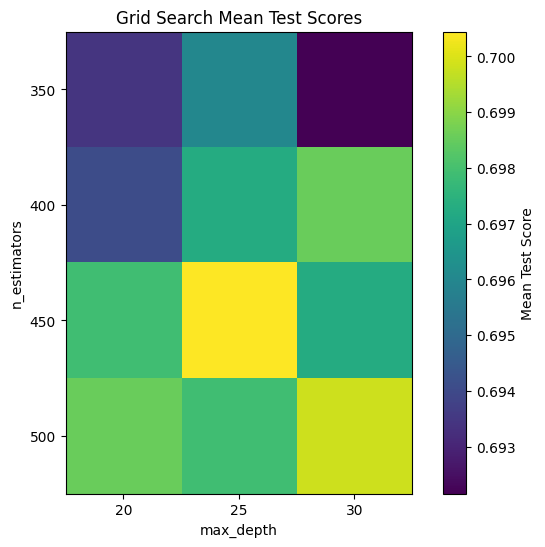

In [ ]:
grid_search = GridSearchCV(clf1, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']))

# Visualize the effect of hyperparameters on model performance (heatmap)
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.colorbar(label='Mean Test Score')
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.yticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.title('Grid Search Mean Test Scores')
plt.show()